# Digital zero noise extrapolation

Zero noise extrapolation (ZNE) is a method introduced by K. Temme et al (2017) [1] and uses the error of the device in order to extrapolate a "noiseless" device. The issue for this approach is that it requires a pulse-level access to a quantum computer, which is not always possible for the user. In this work, they convert this approach systematically for a gate-level access. In this tutorial I will focus on the Gate Folding Method.

# Core Idea

The level of the noise on the system is parametrized by a dimensionless scale factor, $\alpha$. For $\alpha = 0$ we do not have the presence of noise, while for $\alpha = 1$ it is on the noise level of the real hardware. The scale factor could represent any re-scaling of a physical quantity which introduces noise.

We need to measure an expectation value which can be scaled regarding the noise which we call $E(\alpha)$ . By construction, $E(\alpha=1)$ represents the expectation value for the hardware that we are running and $E(\alpha=0)$ is the noiseless expectation value. The procedure is done in two steps:

1. **Noise-Scaling:** Measure $E(\alpha)$ for $m$ different values subjected to $\alpha \geq 1$.
2. **Extrapolation:** Infer $E(0)$ from the data obtained in the previous step.

# Gate Folding:
We fold specific gates on the circuit such that it has the same effect to amplify noise. Let's consider $U = L_d \dots L_1$ such that $L_i$ represents gates or layers in the circuit. If we apply folding for a unique layer $L_i$ we would have:

$$U \rightarrow L_d \dots L_i (L_i^\dagger L_i)^n \dots L_i$$

Thus, the depth of the circuit would scale $d \rightarrow d(1+2n)$. We can also have a partial folding on this kind of setting. Let's define a subset, $S$, of indices from the set of all indices $\{ 1, \dots, d \}$ such that $s = |S|$. We can consider the following gate folding method:

$$ \forall j \in \{ 1, 2, \dots, d \} \hspace{10pt}, \hspace{10pt} L_j = \begin{cases}
      L_j \ (L_j^\dagger L_j)^n, & \text{if}\ j \not \in S \\
      L_j \ (L_j^\dagger L_j)^{n+1}, & \text{if} j \in S \end{cases}$$

There are three different method for creating the subset: from left, from right, and at random. We have the scaling on the number of gates just like unitary folding $d(2n +1) + 2s$. Thus, the scaling is the same $d \rightarrow \alpha d$, where:

$$\alpha = 1 + \frac{2k}{d} \hspace{10pt}, \hspace{10pt} k=1, 2, 3, \dots$$

And we can have the same procedure as the circuit folding to determine $n$ and $s$.

Or for every real $\alpha$, one can apply the procedure:

1. Determine the closest integer $k$ to the real quantity $d(\alpha -1) / 2$.
2. Perform the integer division of $k$ by $d$. The quotient corresponds to $n$ while the remainder to $s$.
3. Apply $n$ integer folds and a final partial folding.

# Example

For this example, let's consider the noise model of a real device `ibmq_santiago`, and a simple circuit that the output should be $| 11 \rangle$. We would like to do the gate folding of the `cx` gate, since it is the gate that generates more noise.

In [14]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import qiskit

from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.providers.aer.noise import NoiseModel
from qiskit.utils import QuantumInstance

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-05-31 17:24:40,953: Credentials are already in use. The existing account in the session will be replaced.


In [23]:
def run_obs(qc, shots, backend_name='ibmq_santiago'):
    """Helper function to get the expected value of the
       | 11 > state.
    """
    
    # Get device noise model
    device = provider.get_backend(backend_name)
    noise_model = NoiseModel.from_backend(device)
    coupling_map = device.configuration().coupling_map
    seed = 42

    # Define the backend
    backend = QuantumInstance(
                            backend=Aer.get_backend("qasm_simulator"),
                            seed_transpiler=seed,
                            optimization_level=1,
                            noise_model=noise_model,
                            shots=shots,
                            )
    qc = qc.copy()
    qc.measure_all()
    counts = backend.execute(qc).get_counts()
    return counts['11']/shots

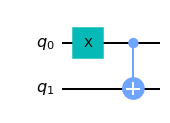

In [24]:
qc = QuantumCircuit(2)
qc.x(0)
qc.cx(0, 1)
qc.draw('mpl')

In [25]:
run_obs(qc, 1000)

0.955

In order to fold the circuit in qiskit, we need to create an auxiliary circuit with the folded gates, for this I will base on another [tutorial](https://nahumsa.github.io/n-blog/2020-09-08-changing-circuits/) that I did where I showed how to change the gate on an existing circuit.

In [48]:
def fold_cx(qc, alpha):
    """ Fold the cx on the circuit given an alpha value.
    """
    d = qc.depth()
    k = np.ceil(d*(alpha - 1)/2)
    n = k//d
    s = k%d
    
    instructions = []
    for instruction, qargs, cargs in qc:
        if instruction.name == 'cx':
            instruction = qiskit.circuit.library.CXGate()
            barrier = qiskit.circuit.library.Barrier(len(qc))
            
            instructions.append((instruction, qargs, cargs))
            instructions.append((barrier, qargs, cargs))
            for _ in range(2*int(n + s)):
                instructions.append((instruction, qargs, cargs))
                instructions.append((barrier, qargs, cargs))
                
        
        else:
            instructions.append((instruction, qargs, cargs))
    
    folded_qc = qc.copy()
    folded_qc.data = instructions
    return folded_qc

Let's collect the circuit given the alpha value.

In [125]:
alpha_list = [1, 2, 5, 7, 9, 11]
folds = []
for alpha in alpha_list:
    folds.append(fold_cx(qc, alpha))

In [126]:
expected_vals = []
for i in range(len(alpha_list)):
    expected_vals.append(run_obs(folds[i], shots=1000))

In [127]:
print(f"Alphas: {alpha_list}\nExpected values{expected_vals}")

Alphas: [1, 2, 5, 7, 9, 11]
Expected values[0.961, 0.941, 0.911, 0.907, 0.87, 0.849]


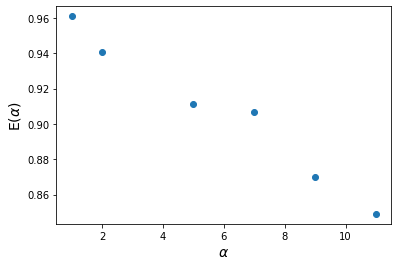

In [128]:
plt.plot(alpha_list, expected_vals, 'o')
plt.xlabel(r"$\alpha$", size=14)
plt.ylabel(r"E($\alpha$)", size=14)
plt.show()

## Extrapolate E(0)
Now that we've colected all $\alpha$ values and $E(\alpha)$ values we can extrapolate the "noiseless" regime. For this case I will use linear extrapolation.

In [129]:
def linear(x, a, b):
    """Linear fit
    """
    return a*x + b

y = expected_vals
x = alpha_list
x, y = np.array(x), np.array(y)

popt, _ = sp.optimize.curve_fit(linear, x, y)
print("Mitigated expectation value:", np.round(popt[1],3))
print("Unmitigated expectation value:", expected_vals[0])

Mitigated expectation value: 0.968
Unmitigated expectation value: 0.961


In [130]:
print("Absolute error with mitigation:", np.round(np.abs(1 - popt[1]), 3))
print("Absolute error without mitigation:", np.round(np.abs(1 - expected_vals[0]), 3))

Absolute error with mitigation: 0.032
Absolute error without mitigation: 0.039


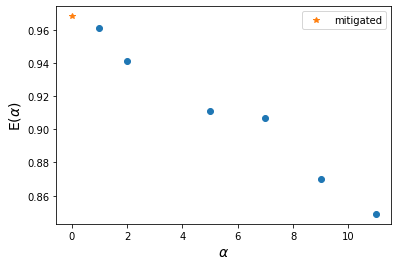

In [133]:
plt.plot(alpha_list, expected_vals, 'o')
plt.plot(0, popt[1], '*', label="mitigated")
plt.xlabel(r"$\alpha$", size=14)
plt.ylabel(r"E($\alpha$)", size=14)
plt.legend()
plt.show()

We can see that we got closer to the ideal value of 1, and got a better result than what we would get from the device without error mitigation!

# References

- [1] - Error mitigation for short-depth quantum circuits - Kristan Temme, Sergey Bravyi, Jay M. Gambetta [arxiv](https://arxiv.org/abs/1612.02058)

- [2] - Digital zero noise extrapolation for quantum error mitigation -Tudor Giurgica-Tiron, Yousef Hindy, Ryan LaRose, Andrea Mari, William J. Zeng - [arxiv](https://arxiv.org/abs/2005.10921)

In [103]:
import qiskit.tools.jupyter
%qiskit_version_table